## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [6]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
train, test = keras.datasets.cifar10.load_data()

In [8]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [9]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import Dropout

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
def build_mlp_2(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = keras.layers.Dense(units=n_units//2, activation="relu")(x)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
            x = keras.layers.Dense(units=n_units//2, activation="relu")(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [12]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXPS = [0.25,0.35]

In [13]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for Dropout_EXP in Dropout_EXPS:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = "1 layer %f" %(Dropout_EXP)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Epoch 50/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.2887 - acc: 0.5410 - val_loss: 1.3097 - val_acc: 0.5323
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____

Epoch 49/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.4117 - acc: 0.4942 - val_loss: 1.3652 - val_acc: 0.5072
Epoch 50/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.4103 - acc: 0.4939 - val_loss: 1.3529 - val_acc: 0.5155


In [16]:
for Dropout_EXP in Dropout_EXPS:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp_2(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = "2 layer %f" %(Dropout_EXP)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

Epoch 44/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.5086 - acc: 0.4563 - val_loss: 1.4647 - val_acc: 0.4730
Epoch 45/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.4998 - acc: 0.4589 - val_loss: 1.4454 - val_acc: 0.4774
Epoch 46/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.5017 - acc: 0.4581 - val_loss: 1.4416 - val_acc: 0.4807
Epoch 47/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.4906 - acc: 0.4598 - val_loss: 1.4458 - val_acc: 0.4800
Epoch 48/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.4799 - acc: 0.4649 - val_loss: 1.4372 - val_acc: 0.4796
Epoch 49/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.4825 - acc: 0.4644 - val_loss: 1.4446 - val_acc: 0.4793
Epoch 50/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.4764 - acc: 0.4687 - val_loss: 1.4264 - val_acc: 0.4886
__________________________________

50000/50000 [==============================] - 4s 86us/step - loss: 1.7633 - acc: 0.3349 - val_loss: 1.6767 - val_acc: 0.3687
Epoch 38/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.7547 - acc: 0.3352 - val_loss: 1.6797 - val_acc: 0.3692
Epoch 39/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.7556 - acc: 0.3321 - val_loss: 1.6626 - val_acc: 0.3706
Epoch 40/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.7487 - acc: 0.3376 - val_loss: 1.6674 - val_acc: 0.3653
Epoch 41/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.7414 - acc: 0.3386 - val_loss: 1.6520 - val_acc: 0.3744
Epoch 42/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.7416 - acc: 0.3417 - val_loss: 1.6577 - val_acc: 0.3745
Epoch 43/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.7352 - acc: 0.3429 - val_loss: 1.6502 - val_acc: 0.3837
Epoch 44/50
50000/50000 [=====================

In [18]:
import pickle
f = open('results.bak', 'wb')
pickle.dump(results, f)

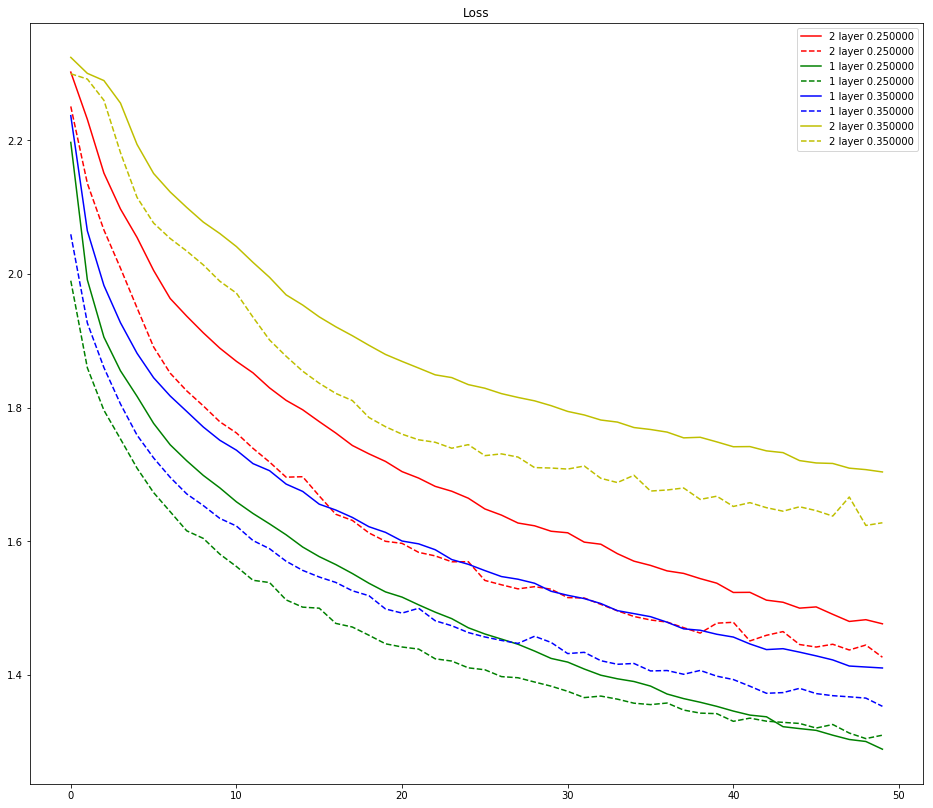

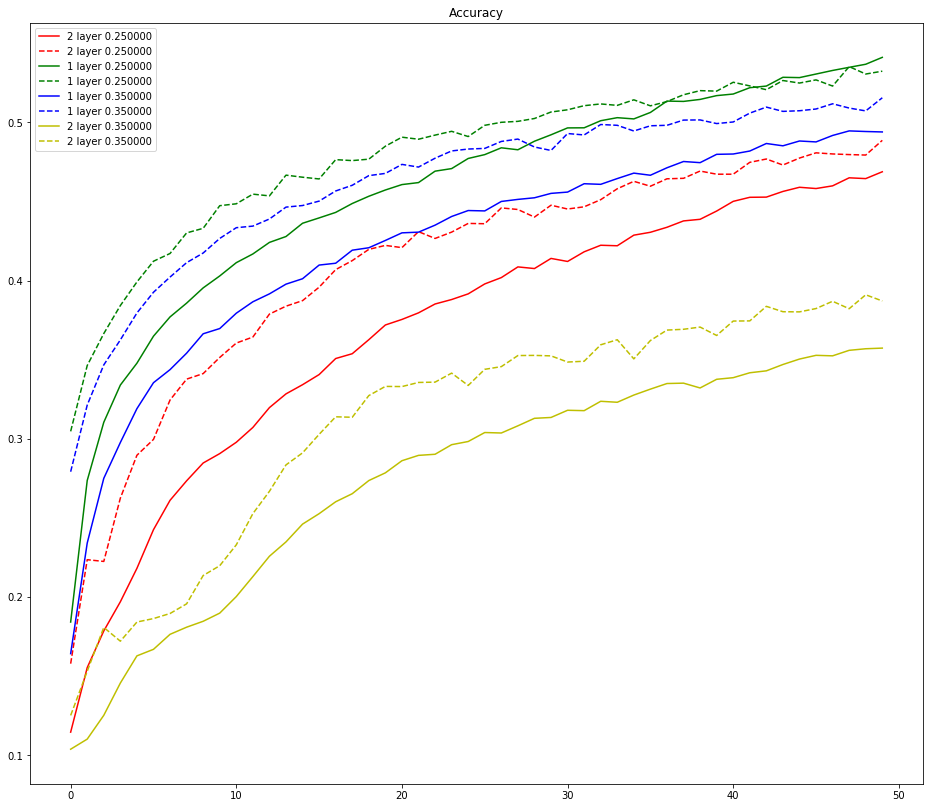

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
